## Effect of probe duration on THz-TDS detection bandwidth
Trying to model the detection (and ideally generation) of THz using EOS, as is done in "Wideband THz Time Domain Spectroscopy based on Optical Rectification and Electro-Optic Sampling" by Tomasino et al. (2013).

Had a quick chat with Matteo about this. He says it is pretty simple, the paper should explain exactly how it is done.
See fig. 4d; This is something like what we want to get, achieved with the equation above this, eq. 12.

### Lvl 1:
Model detection only. Assume delta probe pulse (so Aopt = 1) and consider X2 as constant. Then assume a probe pulse with duration = 245fs, and with 55fs. Compare and show that finite pulse duration limits the bandwidth.

Eqs to use: 13, 14, 15.

Matteo says the paper should explain exactly how this is done. He says delta k is calculated as written below eq. 15.

### Lvl 2:
Model generation as well, then apply the resulting THz bandwidth to Lvl 1 to get some expected bandwidth for our working condition. Show that this transfers experimentally by comparing with data.

## Important quantities:

omega = 2*pi*f

k = 2*pi / lambda

k = omega / v_phase

v_phase = f*lambda

---

Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fft as fft
import pandas as pd

Define constants

In [3]:
res = int(1e2) # resolution of simulation. NOTE: USE THIS FOR ALL LINSPACES!

c = 299792458 # speed of light in vacuum: m/s
L_det = 300e-6 # detection crystal thickness: 300 um
wvl_probe = 1030e-9 # probe wavelength: 1030 nm
freq_thz = 3e12 # THz frequency: 3 THz
t_long = 245e-15
t_short = 55e-15

X2 = 200e-12
# X2 = 0.97e-12 # chi(2) coefficient: pm/V. NOTE: This should be the electro-optic coefficient (I think?)
# In Tomasino et al. they say X2 is the second-order susceptibility for the DFG case (the same as the OR case). Is this the r_41? Or d_41? I... don't know.

freq = np.linspace(1, 10e12, res) # THz frequency range

# E-field constants
E0 = 1e3 # normalise electric field for now
t_pump = 245e-15 # pump pulse duration: 245 fs
n_g = 3.4216 # NOTE: from refractiveindex.info (Parsons and Coleman)
max_time = 10e-12
# max_time = 5e-12
time = np.linspace(0,max_time,res) # 8ps time sample
# v = s/t, so s = v*t
z = c*time # NOTE: this could be another source of error
z = np.linspace(0,1e-9,res)

Define functions

In [4]:
# HELPER FUNCTIONS
# delta k = k_probe(omega_probe) + k(omega_thz) - k_probe(omega_probe - omega_thz)
k = lambda wvl: 2*np.pi / wvl
# omega = 2 * pi * f
omega = lambda freq: 2*np.pi*freq
# lambda = c / f
wvl = lambda freq: c / freq

# FREQUENCY RESPONSE FUNCTIONS
def Aopt(omega, pulseDuration):
    return((np.sqrt(np.pi)/pulseDuration)*np.exp(-(omega**2 * pulseDuration**2)/4))

def deltaPhi(Ldet, delta_k):
    return((np.exp(-1j * delta_k * Ldet) - 1)/(1j * delta_k))

def freq_response(Aopt, X2, deltaPhi):
    return(Aopt*X2*deltaPhi)

# E-FIELD FUNCTIONS
def E1(n_thz, omega):
    return( (E0**2 * X2 * t_pump * np.sqrt(np.pi))/(2*(n_thz**2 - n_g**2)) * np.exp(- (t_pump**2 * omega**2) / 4) )

def E2(n_thz, omega, z):
    return( 0.5*(1 - n_g/n_thz)*np.exp(1j * n_thz * omega * z / c) )

def E3(n_thz, omega, z):
    return( 0.5*(1 + n_g/n_thz)*np.exp(-1j * n_thz * omega * z / c) )

def E4(omega, z):
    return( np.exp(-1j * n_g * omega * z / c) )

def E(n_thz, omega, z):
    return( E1(n_thz, omega)*(E2(n_thz, omega, z) + E3(n_thz, omega, z) - E4(omega, z)) )

#N_THZ CALCULATION
power = lambda x: 1346*(x**-2.373) + 3.34

parsons = pd.read_csv('Parsons.csv')

Try plotting the electric field for some range of z values.

99000990.00990295


Text(0, 0.5, 'Amplitude')

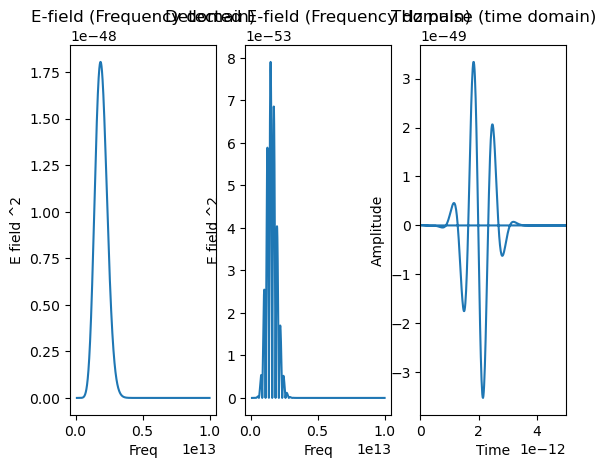

In [16]:
Freq_response = []
E_field = []
E_det = []

res = int(1e5)
z = np.linspace(0,100e-9,res) # I'm not sure why this works... But it seems to work.
freq = np.linspace(0.1e12,10e12,res)
t_pump = 245e-15
t_probe = 245e-15

x = np.linspace(min(parsons['wl']), max(parsons['wl']), res)
n_thz = power(x) # this gives us values of n_thz for all points simulated. R-square is 0.9987

for i, f in enumerate(freq):
    delta_k = k(wvl_probe) + k(wvl(f)) - k(wvl_probe - wvl(f))
    FR = freq_response(Aopt(omega(f), t_probe), X2, deltaPhi(L_det, delta_k))
    EF = E(n_thz[i], omega(f), z[i])

    Freq_response.append(FR)
    E_field.append(EF**2)
    E_det.append(FR*(EF**2))

xlim = 0.5e-11
symmetrical = 0
nfft = 8

sampleSpacing = freq[2] - freq[1]
print(sampleSpacing)

td = fft.fft(np.real(E_det), res*nfft)
xt = fft.fftfreq(res*nfft, sampleSpacing)

plt.subplot(1,3,1)
plt.plot(freq, np.real(E_field))
plt.title("E-field (Frequency domain)")
plt.xlabel("Freq")
plt.ylabel("E field ^2")

plt.subplot(1,3,2)
plt.plot(freq, np.abs(np.real(E_det)))
plt.title("Detected E-field (Frequency domain)")
plt.xlabel("Freq")
plt.ylabel("E field ^2")

plt.subplot(1,3,3)
plt.plot(xt, np.real(td))
plt.xlim([0,5e-12])
plt.title("THz pulse (time domain)")
plt.xlabel("Time")
plt.ylabel("Amplitude")


Text(0, 0.5, 'Amplitude')

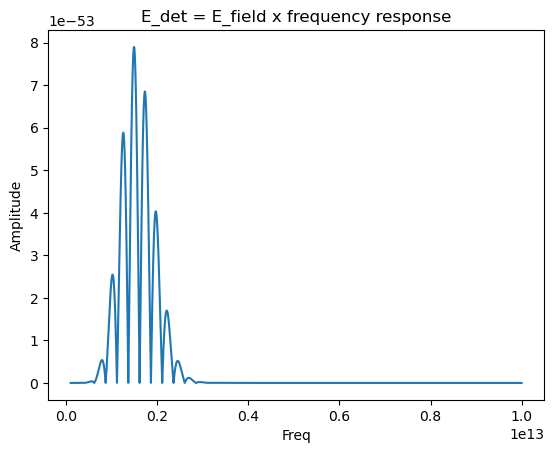

In [6]:
E_det = []
t_probe = 245e-15

for i, f in enumerate(freq):
    delta_k = k(wvl_probe) + k(wvl(f)) - k(wvl_probe - wvl(f))
    FR = freq_response(Aopt(omega(f), t_probe), X2, deltaPhi(L_det, delta_k))
    EF = E(n_thz[i], omega(f), z[i])
    # EF = E(E1(n_thz[i], omega(f)), E2(n_thz[i], omega(f), z[i]), E3(n_thz[i], omega(f), z[i]), E4(omega(f), z[i]))
    E_det.append(FR*(EF**2))

plt.plot(freq, np.abs(np.real(E_det)))
plt.title("E_det = E_field x frequency response")
plt.xlabel('Freq')
plt.ylabel('Amplitude')

99000990.00990295


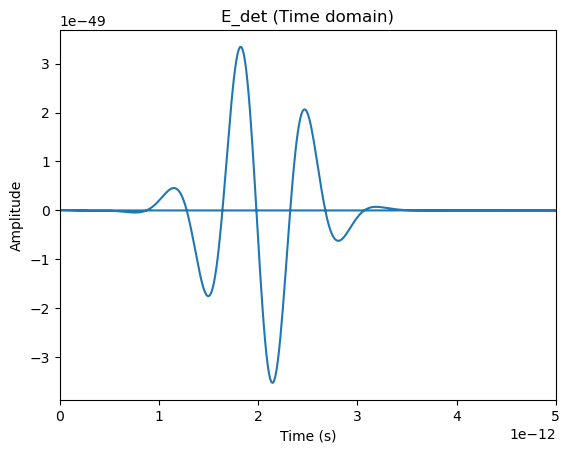

In [7]:
xlim = 0.5e-11
symmetrical = 0
nfft = 8

sampleSpacing = freq[2] - freq[1]
print(sampleSpacing)

td = fft.fft(np.real(E_det), res*nfft)
xt = fft.fftfreq(res*nfft, sampleSpacing)

ax = plt.subplot(111)
if symmetrical:
    ax.set_xlim([-xlim, xlim])
else:
    ax.set_xlim([0, xlim])

plt.title("E_det (Time domain)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.plot(xt,np.real(td))